In [1]:
from numpy import *
from scipy import *
import numpy as np
from matplotlib import *

from scipy import integrate
from scipy import interpolate
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

import xlrd
import xlsxwriter

rc('text',usetex = True)
rc('font', family='serif',size = 12)

In [2]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
Eff = Data.sheet_by_name('Eff')


Effect = []

for i in range(7):
     Effect.append(array(Eff.col_values(i)))

phi = np.arange(0.1,2.01,0.1)
NTU = np.arange(50,351,50)
NN,PP = np.meshgrid(NTU,phi)
Effectiv = interpolate.interp2d(phi,NTU,Effect,kind = 'linear')

In [101]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Cold')

m_f_HEx_c   = array(HEx.col_values(0)) 
Ec_HEx_c   = array(HEx.col_values(1)) 
W_T_HEx_c   = array(HEx.col_values(2)) 
W_f_HEx_c   = array(HEx.col_values(3)) 
W_p_HEx_c   = array(HEx.col_values(4)) 

In [102]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx')
HEx = Data.sheet_by_name('HEx_Hot')

m_f_HEx_h   = array(HEx.col_values(0)) 
Ec_HEx_h   = array(HEx.col_values(1)) 
W_T_HEx_h   = array(HEx.col_values(2)) 
W_f_HEx_h   = array(HEx.col_values(3)) 
W_p_HEx_h   = array(HEx.col_values(4)) 

In [123]:
4*m_f_target[i]/N_circ_hot,ECr_h[i]

(362.5, 0.08463400297434981)

In [127]:
Ec_HEx_h[550]

0.08477741304497144

In [165]:
i = 28
4*m_f_target[i]/N_circ_hot,ECr_h[i]

(362.5, 0.08463400297434981)

In [163]:
abs(ECr_h[i]-Ec_HEx_h[550]),abs(ECr_h[i]-Ec_HEx_h[55])

(0.00014341007062163014, 0.1730113662916547)

In [175]:
HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])

550 559 362.4999999999995 362.4999999999995
550 551 0.08477741304497144 0.08431166907320731


(64.80396117401617, 61.8120898016295, 2.991871372386675)

In [176]:
def HEx_Power(m_f_HEx,W_T_HEx,W_f_HEx,W_p_HEx,Ec_HEx,m_f,ECr):
    A = 0
    B = 9
    
    for i in range(len(m_f_HEx)-1):
        if np.round(m_f,4) == np.round(m_f_HEx[i],4) and np.round(m_f,4) < np.round(m_f_HEx[i+1],4):
            B = i
            #print(B)
            break
    #print(B,m_f,m_f_HEx[B],m_f_HEx[B+1])
    for i in range(B,0,-1):
        if m_f_HEx[i] == m_f_HEx[B]:
            A = i
        else:
            break
    #print(A,B,m_f_HEx[A],m_f_HEx[B])
    C = len(Ec_HEx)-1
    D = len(Ec_HEx)-1
    for i in range(A,B):
        #print(i,C)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[C]) and ECr < Ec_HEx[i]:
            C = i
            #print('oic',C)
    for i in range(B,A,-1):
        #print(i,D)
        if abs(ECr-Ec_HEx[i]) < abs(ECr-Ec_HEx[D]) and ECr > Ec_HEx[i]:
            D = i
            #print('oid',D)
    #print(C,D,Ec_HEx[C],Ec_HEx[D])
    W_T = W_T_HEx[C]+(W_T_HEx[D]-W_T_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_f = W_f_HEx[C]+(W_f_HEx[D]-W_f_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])
    W_p = W_p_HEx[C]+(W_p_HEx[D]-W_p_HEx[C])*(ECr - Ec_HEx[C])/(Ec_HEx[D] - Ec_HEx[C])          
    return(W_T,W_f,W_p)

In [177]:
def Radius(X): 
    R2,R3,B = X
    return (1.41634776*(R2**-1.10684344)*(R3**2.08169412)*(B**0.74232364))

In [178]:
def Qc(X): 
    P1,P2,P3,P4,P5= X #Q_pas_CB,Q_act_CB,Q_span,W_mag,W_p
    return (0.5124256*P1+0.573295*P2-0.52893772*P3-0.00821663*P4-1.2800057*P5)

In [10]:
def Qh(X): 
    P1,P2,P3,P4,P5= X
    return (0.7308924*P1+1.31973655*P2-0.7599739*P3+0.01339801*P4-0.85528785*P5)

In [11]:
def W_Hex(X):
    P1,P2 = X
    return (a*P1**b + c*P2**d)

In [12]:
def Prop_param(X):
    T_c,T_h,B = X
    C_H = 1.65161038/100*T_c+2.59946197*T_h-1.14324309*100*B
    C_L = 10.16443738*T_c-5.32568341*T_h-0.71305997*B
    dT_mg = -0.01057708*T_c+0.01163704*T_h+1.73509682*B
    dT_dmg = -0.01229483*T_c+0.01376157*T_h+0.76454655*B
    CdT_mg = -9.517569*T_c+11.49711993*T_h+820.04168503*B
    CdT_dmg = 4.39480124*T_c-7.07931118/10*T_h+9.15928168*100*B
    return(C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg)

In [13]:
Data = xlrd.open_workbook('AMR_Inputs.xlsx') #Import inputs File
Inputs = Data.sheet_by_name('Data') 

L   = array(Inputs.col_values(0)) #Import AMR Length [mm]
H   = array(Inputs.col_values(1)) #Import AMR Height [mm]
W   = array(Inputs.col_values(2)) #Import AMR Width [mm]
T_c = array(Inputs.col_values(3))+273.15 #Import temperature span [K]
T_h = array(Inputs.col_values(4))+273.15 #Import temperature span [K]
B   = array(Inputs.col_values(5)) #Import magnetic field [T]
f   = array(Inputs.col_values(6)) #Import frequency [Hz]
m_f = array(Inputs.col_values(7))/3600 #Import mass flow rate [kg/h]
Q_c = array(Inputs.col_values(8)) #Import Cooling capacity [W]
Q_h = array(Inputs.col_values(9)) #Import Rejected heat [W]
W_p = array(Inputs.col_values(10)) #Import Pumping power [W]
W_m = array(Inputs.col_values(11)) #Import Magnetic power [W]
T_c_ml = array(Inputs.col_values(12))+273.15 #Import temperature span [K]
T_h_ml = array(Inputs.col_values(13))+273.15 #Import temperature span [K]

Calculation

In [14]:
def Optimal(m_f,FE,f,L,H,W,B,Tc,Th,Tce,The):
    
    ##Properties of the solid 
    rho_s = 7900  #[kg/m3] Density of the solid
    k_s   = 8 #[W/(m2.K)] #Thermal conductivity of the solid

    ## Propertis of the fluid
    rho_f = 1000  #[kg/m3] Density of the fluid
    c_f   = 4181  #[kJ/(kg.K)] # Specific heat of the fluid
    Pr_f  = 6.136 #[-] Prandtl of the fluid
    mu_f  = 0.00061 #0.0008901 #[kg/m-2] #Viscosity of the fluid
    k_f   = 0.6065  #[W/(m2.K)] #Thermal conductivity of the fluid

    ## Porous medium
    d_p = 500*10**(-6) #[m] Particle diameter
    Epsilon = 0.45  #[-] Porosity

    #Magnetic Circuit
    B_rem = 1.35
    N_p = 2
    N_Rp = 2
    
    ### CALCULATION ###
    
    #Porous medium
    m_s   = L*W*H*10**-9*(1-Epsilon)*rho_s #mass of the AMR
    Beta = (1-Epsilon)*6/d_p
    v_s   = (m_f)/(rho_f*W*H*10**-6) #Superficial velocity

    #Dimensionless Numbers
    Re_dp = d_p*v_s*rho_f/((1-Epsilon)*mu_f) #Reynolds number
    Nu = 2*(1+4*(1-Epsilon)/Epsilon)+((1-Epsilon)**0.5)*Re_dp**0.6*Pr_f**(1/3) # Nusselt number
    Pe = Re_dp*Pr_f
    h_int = Nu*k_f/d_p
    NTU_f  = h_int*Beta*(L*W*H*10**(-9))/(m_f*c_f) 
    dP = (L/1000)*(150*(1-Epsilon)**2*mu_f*v_s/(Epsilon**3*d_p**2) + 1.75*(1-Epsilon)*rho_f*v_s**2/(Epsilon**3*d_p))

    #Effective conduction
    k_e_f = k_f*Epsilon #Fluid effective conduction

    a_0 = exp(-1.084-6.778*(Epsilon-0.298))
    f_0 = 0.8
    k_e_s = k_f*((1-a_0)*(Epsilon*f_0+(1-Epsilon*f_0)*k_s/k_f)/(1-Epsilon*(1-f_0)+k_s/k_f*Epsilon*(1-f_0))+a_0*(2*((k_s/k_f)**2)*(1-Epsilon)+(1+2*Epsilon)*k_s/k_f)/((2+Epsilon)*k_s/k_f+(1-Epsilon))) #Solid effective conduction

    D_ = (k_f*rho_f/c_f)*0.75*Pe/2

    k_s_eff = k_e_s
    k_f_eff = k_e_f + rho_f*c_f*D_
    
    ##### Properties Calculation ######   
    C_H,C_L,dT_mg,dT_dmg,CdT_mg,CdT_dmg = Prop_param((Tce,The,B))

    ##### Porous media effectivness #####

    C_HB = ((m_f)*c_f)/(m_s*C_L*f)
    C_CB = ((m_f)*c_f)/(m_s*C_H*f)

    Efness_HB = Effectiv(C_HB/2,NTU_f)
    Efness_CB = Effectiv(C_CB/2,NTU_f)

    #print(Efness_HB,Efness_CB,h_int,Nu,v_s,Re_dp)


    ## Metrics ##

    Q_pas_CB = Efness_CB*(The - Tce)*m_f*FE*c_f
    Q_act_CB = dT_mg*m_f*c_f*FE

    Q_pas_HB = Efness_HB*(The - Tce)*m_f*FE*c_f
    Q_act_HB = dT_dmg*m_f*c_f*FE

    Q_span = (The - Tce)*m_f*c_f*FE
    Q_cond = ((1-Epsilon)*k_s_eff + Epsilon*k_f_eff)*(W*H*10**-6)*(The-Tce)/L
    W_mag  = m_s*f*(CdT_mg - CdT_dmg)
    W_pump = dP*m_f/rho_f*2*(FE)
    #print(Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump)

    ######Calculation#######
    
    N_reg = 4/FE

    Qc_reg = Qc((Q_pas_CB,Q_act_CB,Q_span,W_mag,W_pump))
    Qh_reg = Qh((Q_pas_HB,Q_act_HB,Q_span,W_mag,W_pump))

    #N_reg = Qc_target/Qc_reg
    Qc_target = Qc_reg*N_reg 
    Qh_target = Qh_reg*N_reg

    ECr_c = Qc_target/(FE*N_reg*m_f*c_f*(Tc-Tce))
    ECr_h = Qh_target/(FE*N_reg*m_f*c_f*(The-Th))
    
    B_rem = 1.35
    
    R2 = [W/2+2.5]/np.tan(np.pi/N_reg)
    R_aux = np.sqrt(R2**2-(W/2**2))
    R3 = np.sqrt((H+8+R_aux)**2+(W/2)**2)
    R4 = Radius((R2,R3,1.1*B/B_rem))
    
    W_mag = Qh_reg - Qc_reg - W_pump
    
    
    return (Qc_target,ECr_c,ECr_h,R4,R3,R2,W_mag,W_pump,Qh_target)

In [15]:
Qc_rg = []
Qh_rg = []
W_pump_rg =[]
ECr_c = []
ECr_h = []
N_r = []
R2 = []
R3 = []
R4 = []

for i in range(len(L)):                          
    A1,A2,A3,A4,A5,A6,A7,A8,A9 = Optimal(m_f[i],0.25,f[i],L[i],H[i],W[i],B[i],22+273.15,35+273.15,T_c[i],T_h[i])
    Qc_rg.append(A1)
    Qh_rg.append(A9)
    W_pump_rg.append(A8)
    ECr_c.append(A2)
    ECr_h.append(A3)
    N_r.append(A6)
    R2.append(A6)
    R3.append(A5)
    R4.append(A4)

In [535]:
m_f = np.arange(450,801,5)/3600
FE  = np.arange(25/100,30/100,5/100) 
f = np.arange(1,1.51,0.1)
L = np.arange(140,161,10)
H = np.arange(20,36,5)
W = np.arange(70,71,5)
B_max = np.arange(1.2,1.31,0.05)
Tce = np.arange(10,15,2)
The = np.arange(43,48,2)

In [536]:
len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)

1944

In [537]:
Q_c = []
cont = 0

T_c = 22
T_h = 35

Q_c_target = 2900

m_f_target = []
FE_target = []
f_target = []
L_target = []
H_target = []
W_target = []
Tce_target = []
The_target = []
ECr_c = []
ECr_h = []
R4 = []
R3 = []
R2 = []
W_mag = []
W_pump = []
B_target = []
Q_h = []

for i in range(size(FE)):
    for j in range(len(f)):
        for k in range(len(L)):
            for l in range(len(H)):
                for m in range(len(W)):
                    for n in range(len(Tce)):
                        for o in range(len(The)):
                            for p in range(len(B_max)):
                                it = 0
                                Q_c_system = 0
                                while Q_c_system < Q_c_target and it < len(m_f):
                                    A,B,C,D,E,F,G,A1,A2 = Optimal(m_f[it],FE[i],f[j],L[k],H[l],W[m],B_max[p],T_c+273.15,T_h+273.15,Tce[n]+273.15,The[o]+273.15)
                                    Q_c_system = A[0]
                                    it = it + 1
                                #print(it,Q_c_system)
                                if Q_c_system > Q_c_target:
                                    Q_c.append(Q_c_system)
                                    m_f_target.append(3600*m_f[it-1])
                                    FE_target.append(FE[i])
                                    f_target.append(f[j])
                                    L_target.append(L[k])
                                    H_target.append(H[l])
                                    W_target.append(W[m])
                                    Tce_target.append(Tce[n])
                                    The_target.append(The[o])
                                    B_target.append(B_max[p])
                                    ECr_c.append(B[0])
                                    ECr_h.append(C[0])
                                    R4.append(D[0])
                                    R3.append(E[0])
                                    R2.append(F[0])
                                    W_mag.append(G[0])
                                    W_pump.append(A1)
                                    Q_h.append(A2[0])

                                cont = cont+1
                                print(100*cont/(len(FE)*len(f)*len(L)*len(H)*len(W)*len(Tce)*len(The)*len(B_max)))
                            

0.051440329218107
0.102880658436214
0.15432098765432098
0.205761316872428
0.257201646090535
0.30864197530864196
0.360082304526749
0.411522633744856
0.46296296296296297
0.51440329218107
0.565843621399177
0.6172839506172839
0.668724279835391
0.720164609053498
0.7716049382716049
0.823045267489712
0.8744855967078189
0.9259259259259259
0.977366255144033
1.02880658436214
1.0802469135802468
1.131687242798354
1.183127572016461
1.2345679012345678
1.286008230452675
1.337448559670782
1.3888888888888888
1.440329218106996
1.491769547325103
1.5432098765432098
1.5946502057613168
1.646090534979424
1.6975308641975309
1.7489711934156378
1.800411522633745
1.8518518518518519
1.9032921810699588
1.954732510288066
2.006172839506173
2.05761316872428
2.1090534979423867
2.1604938271604937
2.211934156378601
2.263374485596708
2.314814814814815
2.366255144032922
2.4176954732510287
2.4691358024691357
2.5205761316872426
2.57201646090535
2.623456790123457
2.674897119341564
2.7263374485596708
2.7777777777777777
2.8292

22.94238683127572
22.993827160493826
23.045267489711936
23.096707818930042
23.14814814814815
23.199588477366255
23.25102880658436
23.30246913580247
23.353909465020575
23.405349794238685
23.45679012345679
23.508230452674898
23.559670781893004
23.61111111111111
23.662551440329217
23.713991769547324
23.765432098765434
23.81687242798354
23.868312757201647
23.919753086419753
23.97119341563786
24.022633744855966
24.074074074074073
24.125514403292183
24.17695473251029
24.228395061728396
24.279835390946502
24.33127572016461
24.382716049382715
24.43415637860082
24.48559670781893
24.537037037037038
24.588477366255145
24.63991769547325
24.691358024691358
24.742798353909464
24.79423868312757
24.84567901234568
24.897119341563787
24.948559670781894
25.0
25.051440329218106
25.102880658436213
25.15432098765432
25.20576131687243
25.257201646090536
25.308641975308642
25.36008230452675
25.411522633744855
25.462962962962962
25.51440329218107
25.56584362139918
25.617283950617285
25.66872427983539
25.720164

46.81069958847737
46.86213991769547
46.91358024691358
46.965020576131685
47.016460905349795
47.0679012345679
47.11934156378601
47.17078189300412
47.22222222222222
47.27366255144033
47.325102880658434
47.376543209876544
47.42798353909465
47.47942386831276
47.53086419753087
47.58230452674897
47.63374485596708
47.68518518518518
47.73662551440329
47.788065843621396
47.839506172839506
47.890946502057616
47.94238683127572
47.99382716049383
48.04526748971193
48.09670781893004
48.148148148148145
48.199588477366255
48.251028806584365
48.30246913580247
48.35390946502058
48.40534979423868
48.45679012345679
48.508230452674894
48.559670781893004
48.611111111111114
48.66255144032922
48.71399176954733
48.76543209876543
48.81687242798354
48.86831275720164
48.91975308641975
48.97119341563786
49.022633744855966
49.074074074074076
49.12551440329218
49.17695473251029
49.22839506172839
49.2798353909465
49.33127572016461
49.382716049382715
49.434156378600825
49.48559670781893
49.53703703703704
49.5884773662

70.16460905349794
70.21604938271605
70.26748971193416
70.31893004115226
70.37037037037037
70.42181069958848
70.47325102880659
70.5246913580247
70.57613168724279
70.6275720164609
70.67901234567901
70.73045267489712
70.78189300411523
70.83333333333333
70.88477366255144
70.93621399176955
70.98765432098766
71.03909465020575
71.09053497942386
71.14197530864197
71.19341563786008
71.2448559670782
71.29629629629629
71.3477366255144
71.39917695473251
71.45061728395062
71.50205761316873
71.55349794238683
71.60493827160494
71.65637860082305
71.70781893004116
71.75925925925925
71.81069958847736
71.86213991769547
71.91358024691358
71.96502057613169
72.01646090534979
72.0679012345679
72.11934156378601
72.17078189300412
72.22222222222223
72.27366255144032
72.32510288065843
72.37654320987654
72.42798353909465
72.47942386831275
72.53086419753086
72.58230452674897
72.63374485596708
72.68518518518519
72.73662551440329
72.7880658436214
72.8395061728395
72.89094650205762
72.94238683127573
72.99382716049382

94.34156378600824
94.39300411522633
94.44444444444444
94.49588477366255
94.54732510288066
94.59876543209876
94.65020576131687
94.70164609053498
94.75308641975309
94.8045267489712
94.8559670781893
94.9074074074074
94.95884773662551
95.01028806584362
95.06172839506173
95.11316872427983
95.16460905349794
95.21604938271605
95.26748971193416
95.31893004115226
95.37037037037037
95.42181069958848
95.47325102880659
95.5246913580247
95.57613168724279
95.6275720164609
95.67901234567901
95.73045267489712
95.78189300411523
95.83333333333333
95.88477366255144
95.93621399176955
95.98765432098766
96.03909465020575
96.09053497942386
96.14197530864197
96.19341563786008
96.2448559670782
96.29629629629629
96.3477366255144
96.39917695473251
96.45061728395062
96.50205761316873
96.55349794238683
96.60493827160494
96.65637860082305
96.70781893004116
96.75925925925925
96.81069958847736
96.86213991769547
96.91358024691358
96.96502057613169
97.01646090534979
97.0679012345679
97.11934156378601
97.17078189300412


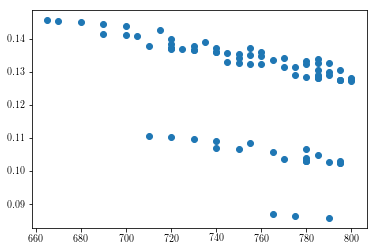

In [538]:
plt.plot(m_f_target,np.array(ECr_h),'o')

for i in range(len(m_f_target)):
    if isnan(W_FT_c[i]) == True:
        print(i)

In [539]:
4*m_f_target[i]/N_circ_hot,ECr_h[i]

(377.5, 0.13740058938543637)

In [540]:
N_circ_cold = 6
N_circ_hot = 8

W_FT_c = np.zeros(len(m_f_target))
W_Ff_c = np.zeros(len(m_f_target))
W_Fp_c = np.zeros(len(m_f_target))

W_FT_h = np.zeros(len(m_f_target))
W_Ff_h = np.zeros(len(m_f_target))
W_Fp_h = np.zeros(len(m_f_target))


for i in range(len(m_f_target)):
    [W_FT_c[i],W_Ff_c[i],W_Fp_c[i]] = HEx_Power(m_f_HEx_c,W_T_HEx_c,W_f_HEx_c,W_p_HEx_c,Ec_HEx_c,4*m_f_target[i]/N_circ_cold,ECr_c[i])
    [W_FT_h[i],W_Ff_h[i],W_Fp_h[i]] = HEx_Power(m_f_HEx_h,W_T_HEx_h,W_f_HEx_h,W_p_HEx_h,Ec_HEx_h,4*m_f_target[i]/N_circ_hot,ECr_h[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_c[i])
    #if W_FT_c[i] == 'Nan':
        #print(4*m_f_target[i]/8,ECr_h[i])

In [541]:
W_p_valve = (2*np.array(m_f_target)/4/1000)**2*10**5**(2*np.array(m_f_target)/3600)/1000*4/np.array(FE_target)
W_valve   = 8*16

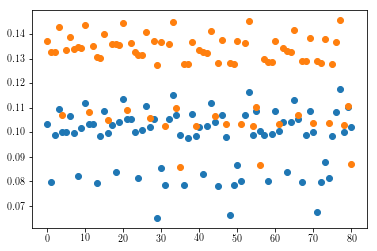

In [542]:
plt.plot(ECr_c,'o')
plt.plot(ECr_h,'o')

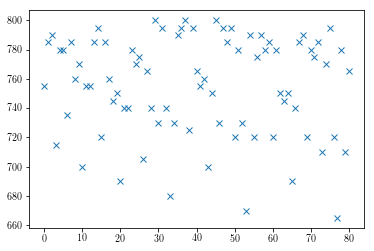

In [543]:
plt.plot(m_f_target,'x')

In [544]:
m_La = 4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(1-0.45)*7000*10**-9
m_Rt = np.pi*((np.array(R4))**2-np.array(R3)**2)*10**-6*(1.3*np.array(L_target)/1000)*7500 #25**2
m_St = np.pi*((np.array(R2)**2))*10**-6*(1.3*np.array(L_target)/1000)*7500
m_Fe = np.pi*((np.array(R4)+40)**2-np.array(R4)**2)*10**-6*(1.3*np.array(L_target)/1000)*7500 #25**2
m_Nd = m_Rt + m_St + m_Fe
m_w  = (4/np.array(FE_target)*np.array(H_target)*np.array(W_target)*np.array(L_target)*(0.45)*1000*10**-9)

In [545]:
m_T = m_La + m_Rt + m_St + m_Fe + m_w
W_T = W_Ff_c + W_Ff_h + W_Fp_c + W_Fp_h +np.array(W_mag)*4/np.array(FE_target) + np.array(W_pump)*4/np.array(FE_target) + W_valve + W_p_valve

In [546]:
m_p = []
W_pa =[]

m_Nd_p = []
m_La_p = []
m_w_p = []

W_p_CHEx_p = []
W_p_CHEx_f = []
W_p_HHEx_p = []
W_p_HHEx_f = []
W_p_mag = []
W_p_pump = []
W_pa_valve = []
W_pa_p_valve = []


m_f_p = []
FE_p  =[]
f_p = []
L_p = []
H_p = []
W_p = []
B_max_p = []
Tce_p = []
The_p = []

R2_p = []
R3_p = []
R4_p = []


for i in range(len(m_T)):
    #print(i)
    A = 0
    for j in  range(len(m_T)):
        if m_T[i] >= m_T[j] and W_T[i] > W_T[j]:
            A = 1
    if A == 0 :
        #print(m_T[i],W_T[i])
        m_p.append(m_T[i])
        m_Nd_p.append(m_Nd[i])
        m_La_p.append(m_La[i])
        m_w_p.append(m_w[i])
        
        m_f_p.append(m_f_target[i])
        FE_p.append(FE_target[i])
        f_p.append(f_target[i])
        L_p.append(L_target[i])
        H_p.append(H_target[i])
        W_p.append(W_target[i])
        B_max_p.append(B_target[i])
        Tce_p.append(Tce_target[i])
        The_p.append(The_target[i])
        
        R2_p.append(R2[i])
        R3_p.append(R3[i])
        R4_p.append(R4[i])
        
        
        
        W_pa.append(W_T[i])
        W_p_CHEx_p.append(W_Fp_c[i])
        W_p_CHEx_f.append(W_Ff_c[i])
        W_p_HHEx_p.append(W_Fp_h[i])
        W_p_HHEx_f.append(W_Ff_h[i])
        W_p_mag.append(np.array(W_mag[i])*4/np.array(FE_target[i]))
        W_p_pump.append(np.array(W_pump[i])*4/np.array(FE_target[i]))
        W_pa_valve.append(W_valve)
        W_pa_p_valve.append(W_p_valve[i])   

Text(0,0.5,'Power [W]')

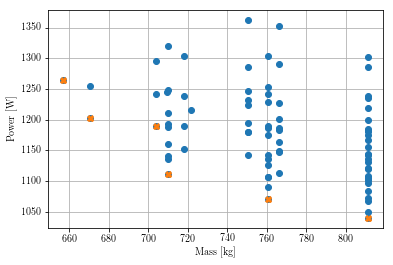

In [547]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
#plt.savefig('Optimum_2Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [548]:
m_W70 = m_p
W_W70 = W_pa

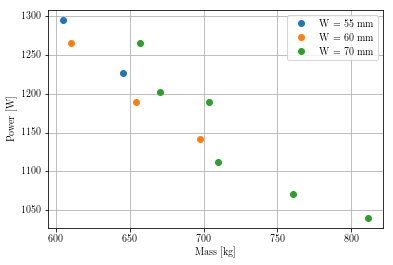

In [549]:
plt.plot(m_W55,W_W55,'o', label = 'W = 55 mm')
plt.plot(m_W60,W_W60,'o', label = 'W = 60 mm')
plt.plot(m_W70,W_W70,'o', label = 'W = 70 mm')

plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend()
plt.savefig('Width.png',format = 'png', dpi=500,bbox_inches='tight')

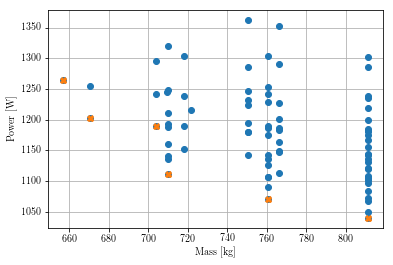

In [550]:
plt.plot(m_T,W_T,'o')
plt.plot(m_p,W_pa,'X')
plt.grid()
#plt.xlim([500,700])
#plt.ylim([1000,2500])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.savefig('Optimum_zoom_1Hz.png',format = 'png', dpi=500,bbox_inches='tight')

In [197]:
dP_AMR = np.array(W_pump)/(np.array(m_f_target)/3600)*1000

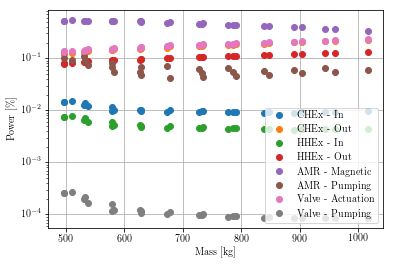

In [198]:
plt.semilogy(m_p,np.array(W_p_CHEx_p)/np.array(W_pa),'o',label = 'CHEx - In')
plt.semilogy(m_p,np.array(W_p_CHEx_f)/np.array(W_pa),'o',label = 'CHEx - Out')
plt.semilogy(m_p,np.array(W_p_HHEx_p)/np.array(W_pa),'o',label = 'HHEx - In')
plt.semilogy(m_p,np.array(W_p_HHEx_f)/np.array(W_pa),'o',label = 'HHEx - Out')
plt.semilogy(m_p,np.array(W_p_mag)/np.array(W_pa),'o',label = 'AMR - Magnetic')
plt.semilogy(m_p,np.array(W_p_pump)/np.array(W_pa),'o',label = 'AMR - Pumping')
plt.semilogy(m_p,np.array(W_pa_valve)/np.array(W_pa),'o',label = 'Valve - Actuation')
plt.semilogy(m_p,np.array(W_pa_p_valve)/np.array(W_pa),'o',label = 'Valve - Pumping')
plt.grid()
plt.xlabel('Mass [kg]')
plt.ylabel('Power [$\%$]')
plt.legend()
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [199]:
workbook = xlsxwriter.Workbook('Optimization_results_1Hz.xlsx')
Data = workbook.add_worksheet('Data')

for i in range(len(m_f_p)):
    Data.write(i,0,m_f_p[i]) 
    Data.write(i,1,FE_p[i])
    Data.write(i,2,f_p[i])
    Data.write(i,3,L_p[i])
    Data.write(i,4,H_p[i])
    Data.write(i,5,W_p[i]) 
    Data.write(i,6,B_max_p[i])
    Data.write(i,7,Tce_p[i])
    Data.write(i,8,The_p[i])
    Data.write(i,9,m_p[i])
    Data.write(i,10,m_Nd_p[i])
    Data.write(i,11,m_La_p[i])
    Data.write(i,12,m_w_p[i])
    Data.write(i,13,W_pa[i])
    Data.write(i,14,W_p_CHEx_p[i])
    Data.write(i,15,W_p_CHEx_f[i])
    Data.write(i,16,W_p_HHEx_p[i])
    Data.write(i,17,W_p_HHEx_f[i])
    Data.write(i,18,W_p_mag[i])
    Data.write(i,19,W_p_pump[i])
    Data.write(i,20,R2_p[i])
    Data.write(i,21,R3_p[i])
    Data.write(i,22,R4_p[i])
    

workbook.close()

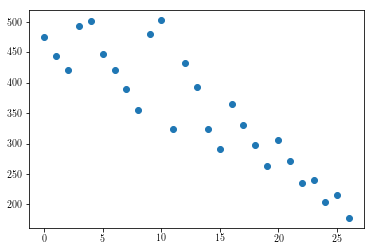

In [200]:
A = W_p_CHEx_f +W_p_CHEx_p
plt.plot(W_p_mag,'o')

In [201]:
W_pa

[900.8919020905455,
 841.0669148909491,
 800.2297087799697,
 934.5272716038648,
 931.3590146252856,
 849.3084983685865,
 800.2297087799697,
 761.268285171712,
 720.0848115796387,
 923.114340560589,
 976.1441782758554,
 690.0049393926362,
 838.7457238125603,
 782.6092405807511,
 695.0810843914384,
 654.2953069256099,
 754.738356035071,
 710.0720178407604,
 667.538956798307,
 626.549569562946,
 683.4893722141891,
 640.416746055268,
 597.3491456850251,
 608.8478933473965,
 565.4259303029163,
 586.1937947169893,
 541.0333326956202]

In [202]:
len(W_p_valve)

1470

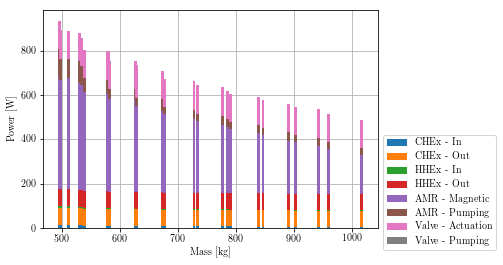

In [203]:
width = 5
plt.grid(zorder = 0)
plt.bar(m_p,W_p_CHEx_p, width, label = 'CHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = W_p_CHEx_p, label = 'CHEx - Out',zorder = 3)
plt.bar(m_p,W_p_HHEx_p, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f), label = 'HHEx - In',zorder = 3)
plt.bar(m_p,W_p_HHEx_f, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p), label = 'HHEx - Out',zorder = 3)
plt.bar(m_p,W_p_mag, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f), label = 'AMR - Magnetic',zorder = 3)
plt.bar(m_p,W_p_pump, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) , label = 'AMR - Pumping',zorder = 3)
plt.bar(m_p,W_pa_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f) + np.array(W_p_mag) + np.array(W_p_pump) , label = 'Valve - Actuation',zorder = 3)
plt.bar(m_p,W_pa_p_valve, width, bottom = np.array(W_p_CHEx_p) + np.array(W_p_HHEx_f)+ np.array(W_p_HHEx_p)+ np.array(W_p_HHEx_f)+ np.array(W_p_mag) + np.array(W_p_pump)+ np.array(W_pa_valve), label = 'Valve - Pumping',zorder = 3)

#plt.xlim([575,865])
plt.xlabel('Mass [kg]')
plt.ylabel('Power [W]')
plt.legend(bbox_to_anchor = (1,0.45))
plt.savefig('Power_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [40]:
m_Rt_p = np.pi*((np.array(R4_p))**2-np.array(R3_p)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2
m_St_p = np.pi*((np.array(R2_p)**2))*10**-6*(1.3*np.array(L_p)/1000)*7500
m_Fe_p_10 = np.pi*((np.array(R4_p)+10)**2-np.array(R4_p)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_20 = np.pi*((np.array(R4_p)+20)**2-(np.array(R4_p)+10)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_40 = np.pi*((np.array(R4_p)+40)**2-(np.array(R4_p)+20)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 
m_Fe_p_80 = np.pi*((np.array(R4_p)+80)**2-(np.array(R4_p)+40)**2)*10**-6*(1.3*np.array(L_p)/1000)*7500 #25**2 

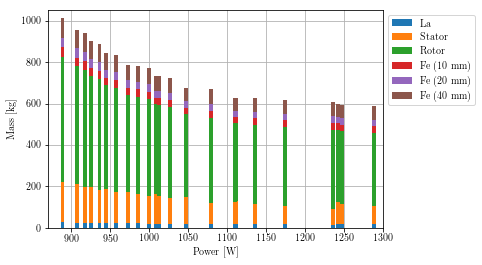

In [50]:
width = 5
plt.grid(zorder = 0)
plt.bar(W_pa,m_La_p, width, label = 'La',zorder = 3)
plt.bar(W_pa,m_St_p, width,bottom = m_La_p, label = 'Stator',zorder = 3)
plt.bar(W_pa,m_Rt_p, width,bottom = np.array(m_La_p) + np.array(m_St_p), label = 'Rotor',zorder = 3)
plt.bar(W_pa,m_Fe_p_10, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p), label = 'Fe (10 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_20, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10), label = 'Fe (20 mm)',zorder = 3)
plt.bar(W_pa,m_Fe_p_40, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20), label = 'Fe (40 mm)',zorder = 3)
#plt.bar(W_pa,m_Fe_p_80, width,bottom = np.array(m_La_p) + np.array(m_St_p)+ np.array(m_Rt_p)+ np.array(m_Fe_p_10)+ np.array(m_Fe_p_20)+ np.array(m_Fe_p_40), label = 'Fe (80 mm)',zorder = 3)
plt.legend( bbox_to_anchor=[1, 1])
plt.ylabel('Mass [kg]')
plt.xlabel('Power [W]')
plt.xlim(870,1300)
plt.ylim(0,1050)
plt.savefig('Mass_Breakdown.png',format = 'png', dpi=500,bbox_inches='tight')

In [42]:
m_p,W_pa

([628.8416689095038,
  677.5777092234468,
  598.7256878311966,
  631.0020661577161,
  734.0425183254007,
  596.2524914443759,
  628.270048807583,
  733.6486137277545,
  790.5073274273547,
  589.8460156712292,
  621.3799988254984,
  673.1464808652674,
  728.079307105057,
  786.0520861368799,
  846.9721365293085,
  611.154979942932,
  776.6179275787274,
  838.4555585460051,
  903.4369456312623,
  890.8590309551305,
  959.9017547332163,
  943.2625033642558,
  1016.3665638351704],
 [1110.7960597159658,
  1047.1235342853874,
  1242.4065738561055,
  1110.4675051063023,
  1008.5569001584053,
  1246.9260344447873,
  1135.5375914568465,
  1012.6299607421571,
  972.1011863834876,
  1288.5713509382683,
  1174.1098978412676,
  1078.9876055624316,
  1026.0358027711263,
  985.5888151832055,
  943.9901023247666,
  1235.9423728628226,
  999.8065177812388,
  957.3658989853099,
  925.4550951429043,
  936.0709899763563,
  907.4972646697432,
  916.8625093788762,
  888.5572727655237])

In [43]:
len(W_pa)

23

ValueError: x and y must have same first dimension, but have shapes (670,) and (216, 1)

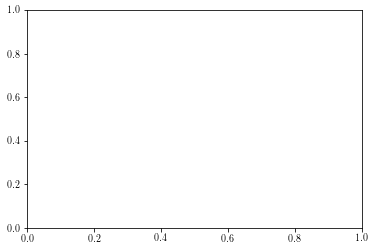

In [44]:
erro_Qc = np.arange(-100,250)
plt.plot(Q_c,np.array(Qc_rg)/16,'o')
plt.plot(erro_Qc,1.1*erro_Qc,'k--')
plt.plot(erro_Qc,0.9*erro_Qc,'k--')
plt.grid()
plt.ylabel('Analytical Cooling Capacity [W]')
plt.xlabel('Numerical Cooling Capacity [W]')
plt.xlim(100,250)
plt.ylim(100,250)
plt.savefig('Qc_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Qh = np.arange(-100,350)
plt.plot(Q_h,np.array(Qh_rg)/16,'o')
plt.plot(erro_Qh,1.1*erro_Qh,'k--')
plt.plot(erro_Qh,0.9*erro_Qh,'k--')
plt.grid()
plt.ylabel('Analytical Rejected Heat [W]')
plt.xlabel('Numerical Rejected Heat [W]')
plt.xlim(120,300)
plt.ylim(120,300)
plt.savefig('Qh_fit.png',format = 'png', dpi=500,bbox_inches='tight')

In [ ]:
erro_Wp = np.arange(0,25)
plt.plot(W_p,W_pump_rg,'o')

plt.plot(erro_Wp,1.1*erro_Wp,'k--')
plt.plot(erro_Wp,0.9*erro_Wp,'k--')
plt.grid()
plt.ylabel('Analytical Pumping Power [W]')
plt.xlabel('Numerical Pumping Power [W]')
#plt.xlim(120,300)
#plt.ylim(120,300)

### Closure Relations

In [ ]:
plt.plot(N_r,R4,'o')

In [ ]:
plt.plot(H,np.array(R3)-np.array(R2),'o')

Regenerator arranges